In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import os

In [51]:
def build_url(place=None):
    
    if place==None:
        place = input("Please enter the name of the place (city, State) you want to search restaurants in (e.g. \"Fremont, CA\"): ")
    
    lst = [x.strip() for x in place.split(',')]
    if len(lst[0].split())>1:
        lst[0] ='+'.join(lst[0].split())
    
    baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
    url = baseurl +lst[0]+',+'+lst[1]
    
    return (url,place)

In [52]:
def query_restaurant(num_restaurant,place=None):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if place==None:
        url,_ = build_url()
    else:
        url,_ = build_url(place)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    #print(df.iloc[:num_restaurant])
    print("\n Top restaurants found\n"+"-"*100)
    for name in restaurant_names[:num_restaurant]:
        print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [53]:
def read_soup_HTML(url):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl

    # Ignore SSL certificate errors
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    # Read the HTML from the URL and pass on to BeautifulSoup
    #print("Opening the page", url)
    uh= urllib.request.urlopen(url, context=ctx)
    html =uh.read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

In [54]:
def build_restaurant_names (soup):
    restaurant_names = []
    for span in soup.find_all('span'):
        if 'class' in span.attrs:
            if span.attrs['class']==['indexed-biz-name']:
                restaurant_names.append(span.contents[1].get_text())
    
    return restaurant_names

In [55]:
def build_restaurant_links (soup):
    restaurant_links=[]
    for a in soup.find_all('a'):
        if 'class' in a.attrs:
            #print(a.attrs)
            if a.attrs['class']==['js-analytics-click']:
                restaurant_links.append(a.attrs['href'])
    _=restaurant_links.pop(0)
    
    for i in range(len(restaurant_links)):
        link='https://yelp.com'+restaurant_links[i]
        restaurant_links[i]=link
    
    return restaurant_links

In [56]:
def gather_reviews(df,num_reviews):
    
    reviews={}
    num_links=df.shape[0]
    num_loop_reviews = 1+int(num_reviews/21)
    
    print("\n")
    
    for i in range(num_links):
        print(f"Gathering top reviews on {df.iloc[i]['Name']} now...")
        
        if num_loop_reviews==1:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
        else:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
            for i in range(1,num_loop_reviews):
                url=df.iloc[i]['Link']+'?start='+str(20*i)
                soup=read_soup_HTML(url)
                for p in soup.find_all('p'):
                    if 'itemprop' in p.attrs:
                        if p.attrs['itemprop']=='description':
                            text=p.get_text().strip()
                            review_text.append(text)
        
        reviews[df.iloc[i]['Name']]=review_text[:num_reviews]
        print(f"Reviews for {df.iloc[i]['Name']} gathered.\n"+"-"*60)
    
    return reviews

In [57]:
def get_reviews(num_restaurant=10,num_reviews=20,place=None):
    if place==None:
        df_restaurants = query_restaurant(num_restaurant=num_restaurant)
    else:
        df_restaurants = query_restaurant(num_restaurant=num_restaurant,place=place)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews)
    
    return reviews

### Test cases

In [77]:
rev = get_reviews(num_restaurant=5,num_reviews=20,place='San Jose, CA')


 Top restaurants found
----------------------------------------------------------------------------------------------------
The Table, Braise, The Funny Farm, Pot Belly Ramen, The Grandview Restaurant, 

Gathering top reviews on The Table now...
Reviews for The Table gathered.
------------------------------------------------------------
Gathering top reviews on Braise now...
Reviews for Braise gathered.
------------------------------------------------------------
Gathering top reviews on The Funny Farm now...
Reviews for The Funny Farm gathered.
------------------------------------------------------------
Gathering top reviews on Pot Belly Ramen now...
Reviews for Pot Belly Ramen gathered.
------------------------------------------------------------
Gathering top reviews on The Grandview Restaurant now...
Reviews for The Grandview Restaurant gathered.
------------------------------------------------------------


In [78]:
rev.keys()

dict_keys(['The Table', 'Braise', 'The Funny Farm', 'Pot Belly Ramen', 'The Grandview Restaurant'])

## Text from reviews

In [81]:
def text_from_reviews(review_dict):
    
    text=""
    
    for restaurant in review_dict:
        text+=('\n'.join(review_dict[restaurant]))
    
    return text

In [62]:
def text_reviews_city(place=None,num_restaurant=10,num_reviews=20):
    
    if place==None:
        review_dict=get_reviews(num_restaurant=num_restaurant,num_reviews=num_reviews)
    else:
        review_dict=get_reviews(num_restaurant=num_restaurant,num_reviews=num_reviews,place=place)
    
    text=""
    
    for restaurant in review_dict:
        text_restaurant = '\n'.join(review_dict[restaurant])
        text+=text_restaurant
    
    return text

In [86]:
text=text_reviews_city(place='Chicago, IL',num_restaurant=5,num_reviews=5)


 Top restaurants found
----------------------------------------------------------------------------------------------------
The Purple Pig, Girl & the Goat, Fusion 58, Au Cheval, Little Bad Wolf, 

Gathering top reviews on The Purple Pig now...
Reviews for The Purple Pig gathered.
------------------------------------------------------------
Gathering top reviews on Girl & the Goat now...
Reviews for Girl & the Goat gathered.
------------------------------------------------------------
Gathering top reviews on Fusion 58 now...
Reviews for Fusion 58 gathered.
------------------------------------------------------------
Gathering top reviews on Au Cheval now...
Reviews for Au Cheval gathered.
------------------------------------------------------------
Gathering top reviews on Little Bad Wolf now...
Reviews for Little Bad Wolf gathered.
------------------------------------------------------------


In [87]:
print(len(text))

25056


## Naive summary

In [88]:
def build_naive_summary(text):
    
    from nltk.tokenize import word_tokenize
    from nltk.tokenize import sent_tokenize
    from nltk.probability import FreqDist
    from nltk.corpus import stopwords
    from collections import OrderedDict
    
    summary_sentences = []
    candidate_sentences = {}
    candidate_sentence_counts = {}
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    words = word_tokenize(striptext)
    lowercase_words = [word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()]
    word_frequencies = FreqDist(lowercase_words)
    most_frequent_words = FreqDist(lowercase_words).most_common(20)
    sentences = sent_tokenize(striptext)
    
    for sentence in sentences:
        candidate_sentences[sentence] = sentence.lower()
    for long, short in candidate_sentences.items():
        count = 0
        for freq_word, frequency_score in most_frequent_words:
            if freq_word in short:
                count += frequency_score
                candidate_sentence_counts[long] = count   
    
    sorted_sentences = OrderedDict(sorted(
                        candidate_sentence_counts.items(),
                        key = lambda x: x[1],
                        reverse = True)[:4])
    
    return sorted_sentences   

In [89]:
summary = build_naive_summary(text)
print(summary)

OrderedDict([('The one thing I would have appreciated is that the burgers/sliders, while delicious, came only with American cheese.', 331), ('The menu is small, but the dishes are delicious with chicken, beef, and seafood.', 314), ("The taste was bland on all three dishes we had chicken boti,grilled salmon, and Bihari kabob...I tried to ask him questions about his experience so far in the neighborhood and his reply was very arrogant like I don't care what people eat in this neighborhood my food is the best, ugh just left a nasty taste in my mouth I give this place a few month to shutter his foods not worth the $13 avg pp he wants to charge.", 312), ('This is a perfect place to go with a group of people in order to try all their delicious dishes.', 309)])


## Gensim summarization

In [90]:
summary_sentences = []
candidate_sentences = {}
candidate_sentence_counts = {}
striptext = text.replace('\n\n', ' ')
striptext = striptext.replace('\n', ' ')

In [91]:
import gensim.summarization

In [92]:
summary = gensim.summarization.summarize(striptext, word_count=100) 
print(summary)

This is a perfect place to go with a group of people in order to try all their delicious dishes.
Ordered the Buttersquash Empanadas (black truffle oil, squash, cheese filling with apple sauce demiglaze and the cutest melted marshmallow pillow on a cinnamon stick), Pork Ossabuco, Red Snapper on red cabbage sauce, Octopus with potatoes and asparagus, and a Fried Hash & Chorizo dish I cannot remember the name of.


## Dispersion plot

In [94]:
text=text_reviews_city(place='Palo Alto, CA',num_restaurant=10,num_reviews=20)


 Top restaurants found
----------------------------------------------------------------------------------------------------
La Bodeguita Del Medio, Dumpling City, Evvia Estiatorio, Coconuts Caribbean Restaurant & Bar, Bevri, So Gong Dong Tofu House, Hidden Garden Sushi, True Food Kitchen, Bird Dog, Tamarine Restaurant, 

Gathering top reviews on La Bodeguita Del Medio now...
Reviews for La Bodeguita Del Medio gathered.
------------------------------------------------------------
Gathering top reviews on Dumpling City now...
Reviews for Dumpling City gathered.
------------------------------------------------------------
Gathering top reviews on Evvia Estiatorio now...
Reviews for Evvia Estiatorio gathered.
------------------------------------------------------------
Gathering top reviews on Coconuts Caribbean Restaurant & Bar now...
Reviews for Coconuts Caribbean Restaurant & Bar gathered.
------------------------------------------------------------
Gathering top reviews on Bevri now..

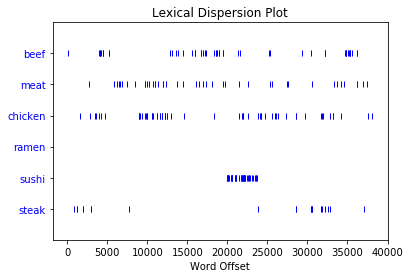

In [95]:
from nltk.stem.porter import PorterStemmer
import nltk
from nltk import sent_tokenize,word_tokenize

p_stemmer = PorterStemmer()
striptext = text.replace('\n\n', ' ')
striptext = striptext.replace('\n', ' ')
sentences = sent_tokenize(striptext)
words = word_tokenize(striptext)
text_for_dispersion = nltk.Text([p_stemmer.stem(i).lower() for i in words])
text_for_dispersion.dispersion_plot(['beef','meat','chicken','ramen','sushi','steak'])

## Vader Sentiment Analysis

In [97]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Run a Gensim summarization on the large text and then try sentiment analysis

In [98]:
striptext = text.replace('\n\n', ' ')
striptext = striptext.replace('\n', ' ')
import gensim.summarization
summary = gensim.summarization.summarize(striptext, word_count=500)

In [101]:
from nltk.tokenize import sent_tokenize

headers = ['pos','neg','neu','compound']
analyzer = SentimentIntensityAnalyzer()
sentences = sent_tokenize(summary)
pos=compound=neu=neg=0
for sentence in sentences:
    print(sentence)
    vs = analyzer.polarity_scores(sentence)
    #pos+=vs['pos']/(len(sentences))
    #compound+=vs['compound']/(len(sentences))
    #neu+=vs['neu']/(len(sentences))
    #neg+=vs['neg']/(len(sentences))
    print(str(vs['pos']),str(vs['neg']),str(vs['neu']))

We went here for lunch and want to order food but the place wasn't ready to handle too many customers.
0.053 0.122 0.825
The server was really friendly and got us started with ice cold Ouzo :) For appetizers we ordered a lamb dish which was the special of the day.
0.277 0.0 0.723
We both got grilled lamb chops-- ordered medium rare and medium because we knew some places may not get it perfectly done...came out medium and medium well but we enjoyed it flavor wise.
0.246 0.053 0.702
Mushrooms, fried little fish appertizers taste amazing!Good place specially if you are sitting outside.
0.0 0.0 1.0
Overall service was good, they were attentive and food wasn't over the top but I'd definitely come back for appetizers and drinks!
0.222 0.05 0.728
We went for an early dinner and we were one of the few tables there so food service was timely (20 minutes for our order).
0.0 0.0 1.0
Beet salad was so fresh & beautiful  Khachapuris were heavenly Lamb chops delicious w just enough tenderness & char